# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

![](static/privacygan_titatic_preprocessing.png)

### Dataset 01: Titanic
- source: https://www.kaggle.com/c/titanic/data
- predict the survival based on passenger information

In [3]:
df_data = pd.read_csv('data/titanic.csv')
len_prev = len(df_data)
df_data.drop(['Cabin'], axis=1, inplace=True)
df_data.dropna(inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))
df_data.head(3)

179 rows with null values dropped
712 rows of data available


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [4]:
for col in ['Name', 'Sex', 'Embarked', 'Ticket']:
    df_data[col+'_preprocessed'] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_preprocessed,Sex_preprocessed,Embarked_preprocessed,Ticket_preprocessed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,braund mr owen harris,male,s,a 5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,cumings mrs john bradley florence briggs thayer,female,c,pc 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,heikkinen miss laina,female,s,ston o2 3101282


### Visualizations

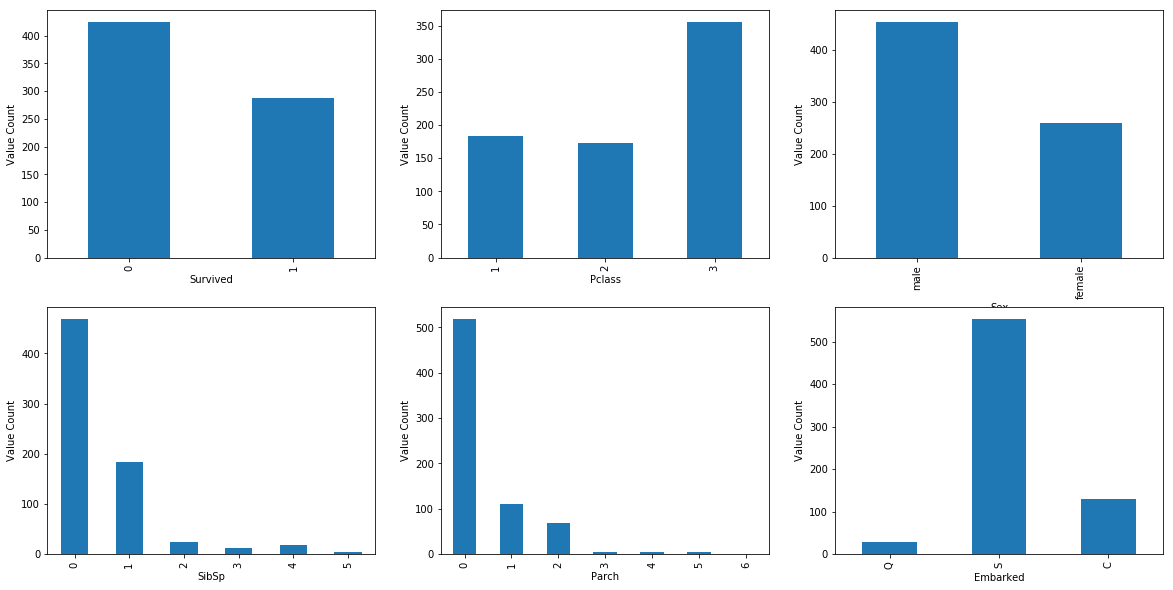

In [5]:
categorical_columns = [
    'Survived', 
    'Pclass', 
    'Sex', 
    'SibSp', 
    'Parch', 
    'Embarked'
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

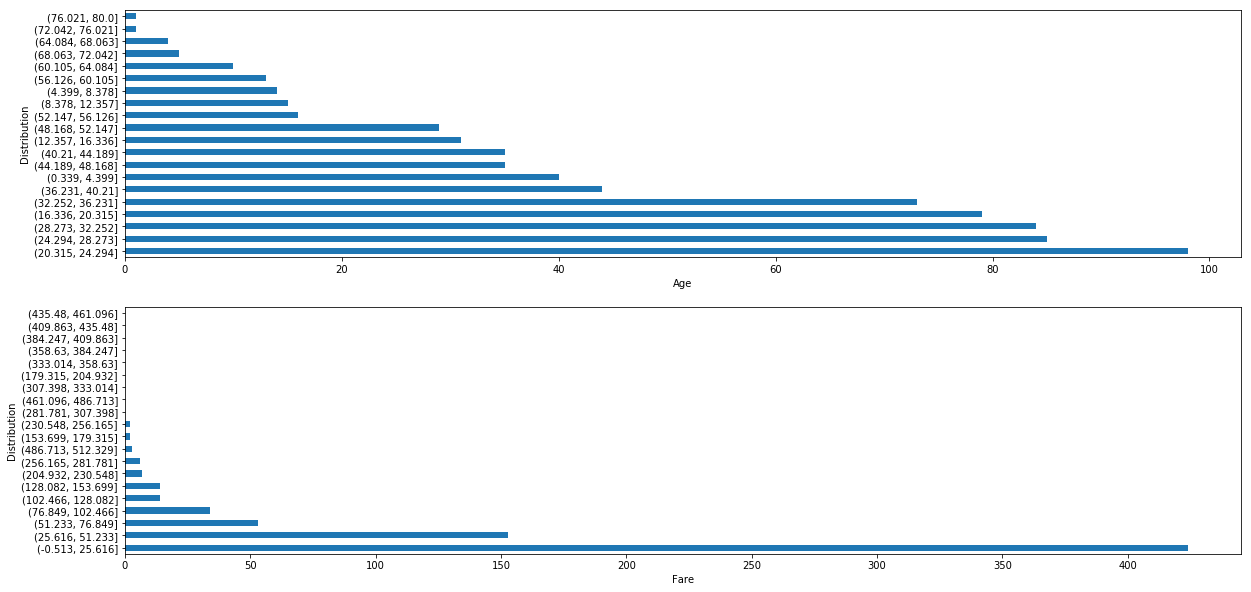

In [6]:
continuous_variables = [
    'Age', 
    'Fare'
]

num_cols = 1
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(continuous_variables)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[continuous_variables[col]].value_counts(bins=20, sort=True).plot(kind='barh')
    plt.xlabel(continuous_variables[col])
    plt.ylabel('Distribution')
plt.show()


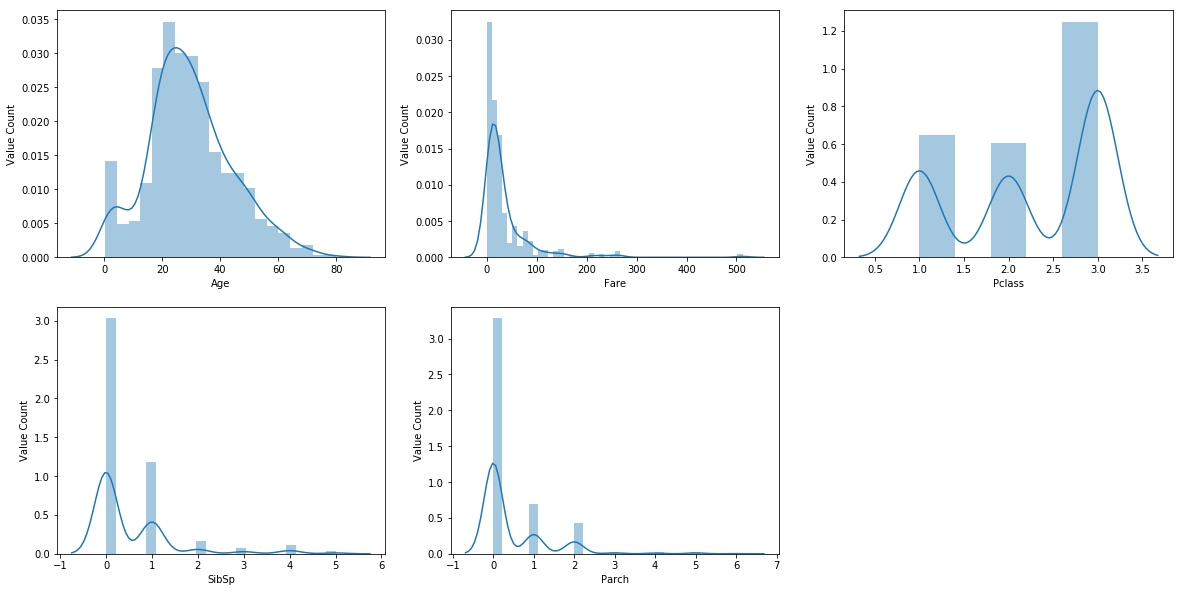

In [7]:
dist_columns = [
    'Age',
    'Fare',
    'Pclass',
    'SibSp',
    'Parch'
]

num_cols = 3
num_rows = math.ceil(len(dist_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(dist_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    sns.distplot(df_data[dist_columns[col]])
    plt.xlabel(dist_columns[col])
    plt.ylabel('Value Count')
plt.show()

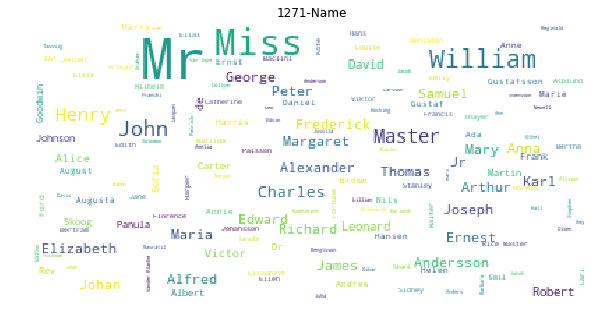

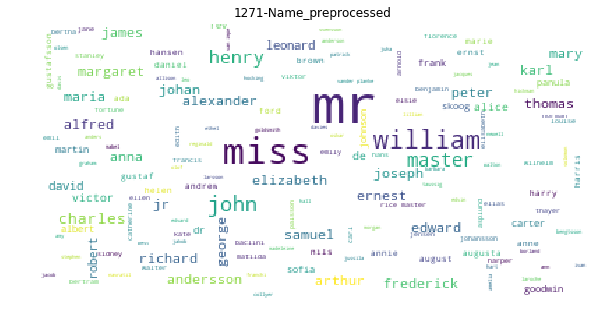

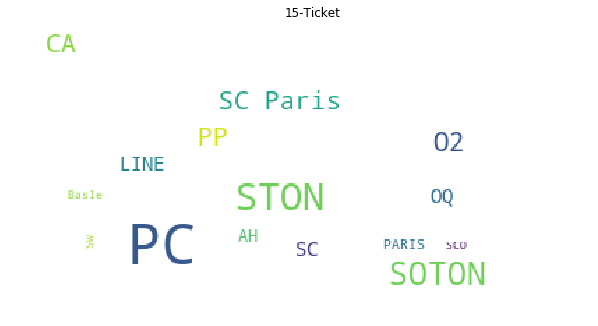

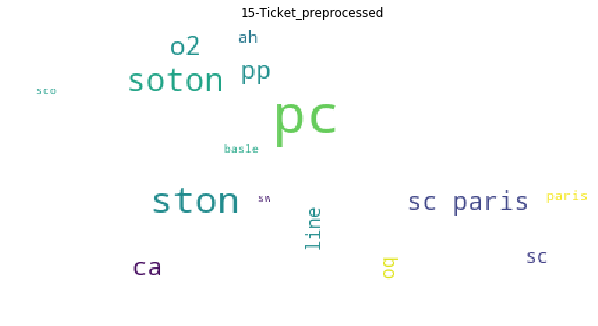

In [8]:
text_columns = ['Name', 'Name_preprocessed', 'Ticket', 'Ticket_preprocessed']

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [9]:
for col in ["Name", "Sex", "Embarked", "Ticket"]:
    df_data[col] = df_data[col+"_preprocessed"]
    df_data.drop([col+"_preprocessed"], axis=1, inplace=True)
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,braund mr owen harris,male,22.0,1,0,a 5 21171,7.2500,s
1,2,1,1,cumings mrs john bradley florence briggs thayer,female,38.0,1,0,pc 17599,71.2833,c
2,3,1,3,heikkinen miss laina,female,26.0,0,0,ston o2 3101282,7.9250,s


In [10]:
df_data = pd.get_dummies(df_data, columns=['Sex'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'])
df_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Sex_male,Pclass_1,Pclass_2,Pclass_3,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,1,0,braund mr owen harris,22.0,a 5 21171,7.2500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,1,cumings mrs john bradley florence briggs thayer,38.0,pc 17599,71.2833,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,heikkinen miss laina,26.0,ston o2 3101282,7.9250,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1,futrelle mrs jacques heath lily may peel,35.0,113803,53.1000,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,allen mr william henry,35.0,373450,8.0500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [11]:
y_ally = np.array(df_data.Survived.tolist())
y_advr = np.array(df_data.Sex_male.tolist())

df_data.drop(['Survived', 'Sex_male'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [12]:
vectorizer = CountVectorizer()
Name = vectorizer.fit_transform(df_data.Name.tolist()).toarray()
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
Ticket = vectorizer.fit_transform(df_data.Ticket.tolist()).toarray()

In [13]:
df_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df_data.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,22.0,7.2500,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [14]:
X = np.concatenate((df_data.values, Name, Ticket), axis=1)
y_ally.shape, y_advr.shape, X.shape

((712,), (712,), (712, 1324))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [15]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((640, 1324), (72, 1324), (640,), (72,), (640,), (72,))

### Checking the distribution after the split

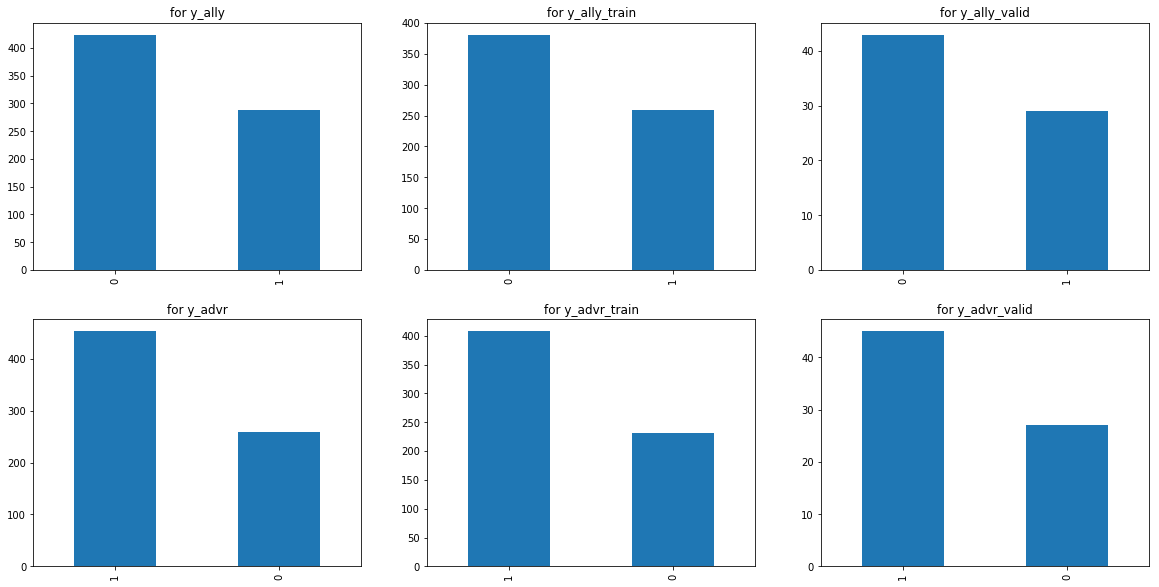

In [16]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [17]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

![](static/privacygan_titanic_experiment.png)

### Apply PCA and select components using explained variances

In [18]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [19]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9901699196570167 588


In [20]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((640, 588), (72, 588))

### Apply Auto-encoder for dimensionality reduction

![](static/privacygan_titanic_autoencoder.png)

In [21]:
import torch
import torch.utils.data as utils
import torch.nn as nn

In [22]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

X_train_torch = torch.Tensor(X_train_normalized).to(device)
X_valid_torch = torch.Tensor(X_valid_normalized).to(device)
y_ally_train_torch = torch.Tensor(y_ally_train.reshape(-1, 1)).to(device)
y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1)).to(device)
y_advr_train_torch = torch.Tensor(y_advr_train.reshape(-1, 1)).to(device)
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 1)).to(device)

DType: torch.float32
Cuda available: True
Device: cuda


In [23]:
X_train_torch.shape, X_valid_torch.shape, \
y_ally_train_torch.shape, y_ally_valid_torch.shape, \
y_advr_train_torch.shape, y_advr_valid_torch.shape

(torch.Size([640, 1324]),
 torch.Size([72, 1324]),
 torch.Size([640, 1]),
 torch.Size([72, 1]),
 torch.Size([640, 1]),
 torch.Size([72, 1]))

In [24]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [28]:
auto_encoder = AutoEncoder(input_size=X_train.shape[1],encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

In [26]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(501):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_train_torch_hat = auto_encoder(X_train_torch)
    ae_loss = criterion(X_train_torch_hat, X_train_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    if epoch%50!=0:
        continue
        
    auto_encoder.eval()
    
    X_valid_torch_hat = auto_encoder(X_valid_torch)
    ae_valid_loss = criterion(X_valid_torch_hat, X_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss
    ))
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 1.18268251 	 0.69649345
50 	 0.84766257 	 0.42243785
100 	 0.83807397 	 0.41295907
150 	 0.83686644 	 0.41136435
200 	 0.83662301 	 0.41068214
250 	 0.83651304 	 0.41025418
300 	 0.83645040 	 0.40995076
350 	 0.83641106 	 0.40972161
400 	 0.83638328 	 0.40954304
450 	 0.83636177 	 0.40940899
500 	 0.83634758 	 0.40928984


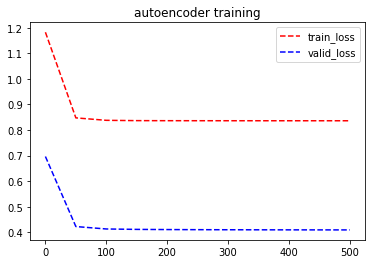

In [29]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [30]:
auto_encoder.eval()
X_train_torch_ae = auto_encoder.encoder(X_train_torch)
X_valid_torch_ae = auto_encoder.encoder(X_valid_torch)
X_train_torch_ae.shape, X_valid_torch_ae.shape

(torch.Size([640, 588]), torch.Size([72, 588]))

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

![](static/privacygan_titanic_privacygan.png)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [31]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [32]:
alpha = 0.5

In [50]:
encoding_dimension = X_train_reduced.shape[1]
encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1]).cuda()
adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1]).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
encd_optimizer = optimizer(encoder.parameters(), lr = 0.001)
ally_optimizer = optimizer(ally.parameters(), lr=0.0001)
advr_optimizer = optimizer(adversary.parameters(), lr=0.001)

In [51]:
print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

g_epoch = []
enc_train = []
enc_valid = []
ally_train = []
ally_valid = []
advr_train = []
advr_valid = []

for epoch in range(51):
    # set for training
    encoder.train()
    ally.train()
    adversary.train()
    
    encd_optimizer.zero_grad()
    # Forward passv
    X_train_encoding = encoder(X_train_torch)
    y_ally_train_torch_hat = ally(X_train_encoding)
    y_advr_train_torch_hat = adversary(X_train_encoding)
    # Compute Loss
    ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
    # Backward pass
    encd_loss.backward(retain_graph=True)
    encd_optimizer.step()

    for i in range(10):
        ally_optimizer.zero_grad()
        advr_optimizer.zero_grad()

        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        
        ally_loss.backward(retain_graph=True)
        advr_loss.backward(retain_graph=True)

        ally_optimizer.step()
        advr_optimizer.step()
        
    if epoch%10!=0:
        continue

    # set for eval
    encoder.eval()
    ally.eval()
    adversary.eval()
    
    X_valid_encoding = encoder(X_valid_torch)
    y_ally_valid_torch_hat = ally(X_valid_encoding)
    y_advr_valid_torch_hat = adversary(X_valid_encoding)

    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)
        
    print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        encd_loss.item(),
        encd_valid_loss,
        ally_loss.item(), 
        ally_valid_loss,
        advr_loss.item(),
        advr_valid_loss,
    ))
    
    g_epoch.append(epoch)
    enc_train.append(encd_loss.item())
    enc_valid.append(encd_valid_loss.item())
    ally_train.append(ally_loss.item())
    ally_valid.append(ally_valid_loss.item())
    advr_train.append(advr_loss.item())
    advr_valid.append(advr_valid_loss.item())

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 0.05891293 	 0.04193938 	 0.73813832 	 0.73943603 	 0.65425956 	 0.66154939
10 	 0.04279053 	 0.05556604 	 0.69441408 	 0.69660419 	 0.58328199 	 0.64530277
20 	 0.00828716 	 0.00802442 	 0.69181144 	 0.69410497 	 0.67576259 	 0.68826175
30 	 -0.04076055 	 -0.04534858 	 0.58506519 	 0.68175668 	 0.67576236 	 0.68826175
40 	 -0.06679228 	 -0.06727710 	 0.54120749 	 0.68088442 	 0.67576170 	 0.68826169
50 	 -0.06808621 	 -0.06809628 	 0.53956908 	 0.68148643 	 0.67576164 	 0.68826169


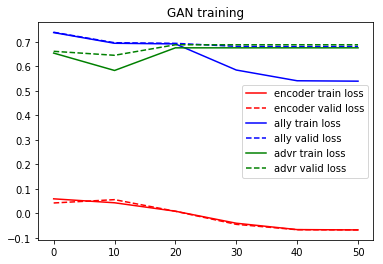

In [52]:
plt.plot(g_epoch, enc_train, 'r')
plt.plot(g_epoch, enc_valid, 'r--')
plt.plot(g_epoch, ally_train, 'b')
plt.plot(g_epoch, ally_valid, 'b--')
plt.plot(g_epoch, advr_train, 'g')
plt.plot(g_epoch, advr_valid, 'g--')
plt.legend([
    'encoder train loss', 
    'encoder valid loss',
    'ally train loss',
    'ally valid loss',
    'advr train loss',
    'advr valid loss'
])
plt.title("GAN training")
plt.show()

# Ally and Adversary Learning on Encoded Data

In [53]:
X_train_encoded = encoder(X_train_torch)
X_valid_encoded = encoder(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape

(torch.Size([640, 588]), torch.Size([72, 588]))

In [54]:
X_train_reduced.shape, X_valid_reduced.shape

((640, 588), (72, 588))

In [55]:
y_ally_train_torch.shape, y_ally_valid_torch.shape

(torch.Size([640, 1]), torch.Size([72, 1]))

In [56]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [58]:
lr = 0.0001

network = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

n_epoch = []
train = []
valid = []
for epoch in range(501):
    network.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network(X_train_encoded)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network.eval()
    y_ally_valid_torch_hat = network(X_valid_encoded)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    n_epoch.append(epoch)
    train.append(loss.item())
    valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.78870392 	 0.78590584
50 	 0.64572370 	 0.71514261
100 	 0.59720290 	 0.70407701
150 	 0.57683575 	 0.69766039
200 	 0.56640804 	 0.69408000
250 	 0.56017774 	 0.69189388
300 	 0.55606914 	 0.69045353
350 	 0.55317289 	 0.68945390
400 	 0.55103153 	 0.68873280
450 	 0.54939073 	 0.68819630
500 	 0.54809821 	 0.68778706


In [59]:
lr = 0.001

network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

train_a = []
valid_a = []

for epoch in range(501):
    network_advr.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr(X_train_encoded)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr.eval()
    y_advr_valid_torch_hat = network_advr(X_valid_encoded)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    train_a.append(loss.item())
    valid_a.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65518349 	 0.65490657
50 	 0.54958242 	 0.65331942
100 	 0.51201928 	 0.60963321
150 	 0.46890545 	 0.58594918
200 	 0.46344978 	 0.58233535
250 	 0.46092567 	 0.58024830
300 	 0.45914769 	 0.57966775
350 	 0.45772645 	 0.57978809
400 	 0.45655367 	 0.57998800
450 	 0.45563337 	 0.57993883
500 	 0.45493823 	 0.57965893


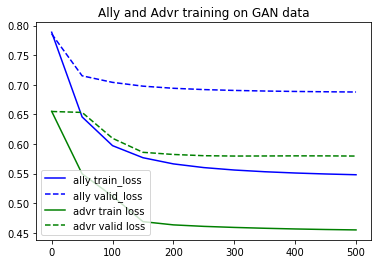

In [60]:
plt.plot(n_epoch, train, 'b')
plt.plot(n_epoch, valid, 'b--')
plt.plot(n_epoch, train_a, 'g')
plt.plot(n_epoch, valid_a, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on GAN data")
plt.show()

In [61]:
alphas = [0, 0.25, 0.5, 0.75, 1]

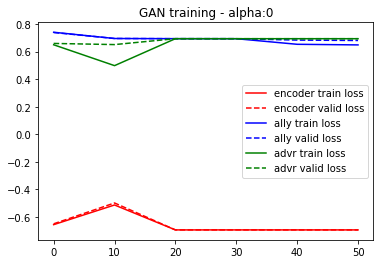

0 0.5480832457542419 0.6877537965774536
0 0.454600065946579 0.5796026587486267


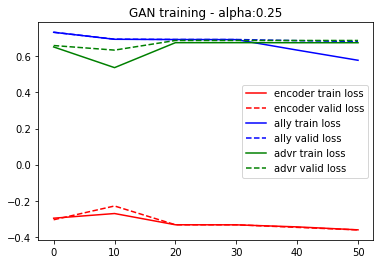

0.25 0.5467740297317505 0.6866220831871033
0.25 0.4545614421367645 0.5795859098434448


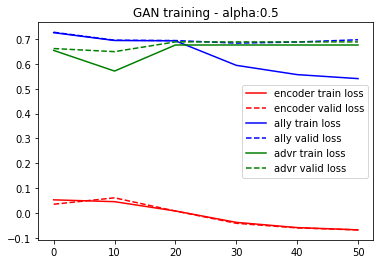

0.5 0.546849250793457 0.6865354180335999
0.5 0.4548822343349457 0.5794680118560791


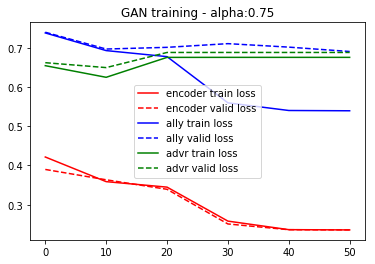

0.75 0.5460478067398071 0.6856242418289185
0.75 0.4548777639865875 0.5794234871864319


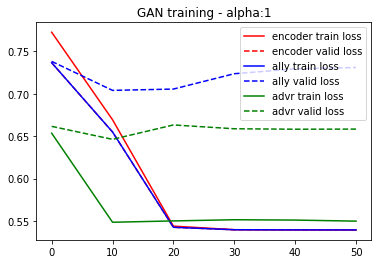

1 0.5460934042930603 0.6847606897354126
1 0.4550647735595703 0.5794736742973328


In [67]:
gan_ally_over_alpha = []
gan_advr_over_alpha = []
for alpha in alphas:
    encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
    ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1]).cuda()
    adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1]).cuda()

    encd_optimizer = optimizer(encoder.parameters(), lr = 0.001)
    ally_optimizer = optimizer(ally.parameters(), lr=0.0001)
    advr_optimizer = optimizer(adversary.parameters(), lr=0.001)
    
    g_epoch = []
    enc_train = []
    enc_valid = []
    ally_train = []
    ally_valid = []
    advr_train = []
    advr_valid = []

    for epoch in range(51):
        # set for training
        encoder.train()
        ally.train()
        adversary.train()

        encd_optimizer.zero_grad()
        # Forward passv
        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        # Compute Loss
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
        # Backward pass
        encd_loss.backward(retain_graph=True)
        encd_optimizer.step()

        for i in range(10):
            ally_optimizer.zero_grad()
            advr_optimizer.zero_grad()

            X_train_encoding = encoder(X_train_torch)
            y_ally_train_torch_hat = ally(X_train_encoding)
            y_advr_train_torch_hat = adversary(X_train_encoding)

            ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
            advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)

            ally_loss.backward(retain_graph=True)
            advr_loss.backward(retain_graph=True)

            ally_optimizer.step()
            advr_optimizer.step()

        if epoch%10!=0:
            continue

        # set for eval
        encoder.eval()
        ally.eval()
        adversary.eval()

        X_valid_encoding = encoder(X_valid_torch)
        y_ally_valid_torch_hat = ally(X_valid_encoding)
        y_advr_valid_torch_hat = adversary(X_valid_encoding)

        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
        encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)

        g_epoch.append(epoch)
        enc_train.append(encd_loss.item())
        enc_valid.append(encd_valid_loss.item())
        ally_train.append(ally_loss.item())
        ally_valid.append(ally_valid_loss.item())
        advr_train.append(advr_loss.item())
        advr_valid.append(advr_valid_loss.item())
        
    plt.plot(g_epoch, enc_train, 'r')
    plt.plot(g_epoch, enc_valid, 'r--')
    plt.plot(g_epoch, ally_train, 'b')
    plt.plot(g_epoch, ally_valid, 'b--')
    plt.plot(g_epoch, advr_train, 'g')
    plt.plot(g_epoch, advr_valid, 'g--')
    plt.legend([
        'encoder train loss', 
        'encoder valid loss',
        'ally train loss',
        'ally valid loss',
        'advr train loss',
        'advr valid loss'
    ])
    plt.title("GAN training - alpha:" + str(alpha))
    plt.show()


    lr = 0.0001

    network = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network.parameters(), lr=lr)    

    for epoch in range(501):
        network.train()
        net_optimizer.zero_grad()

        y_ally_train_torch_hat = network(X_train_encoded)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

    # set for eval
    network.eval()
    y_ally_valid_torch_hat = network(X_valid_encoded)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

    print(alpha, loss.item(), ally_valid_loss.item())
    gan_ally_over_alpha.append(ally_valid_loss.item())
    
    
    lr = 0.001

    network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

    for epoch in range(501):
        network_advr.train()
        net_optimizer.zero_grad()

        y_advr_train_torch_hat = network_advr(X_train_encoded)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

    # set for eval
    network_advr.eval()
    y_advr_valid_torch_hat = network_advr(X_valid_encoded)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    gan_advr_over_alpha.append(advr_valid_loss.item())
    print(alpha, loss.item(), advr_valid_loss.item())

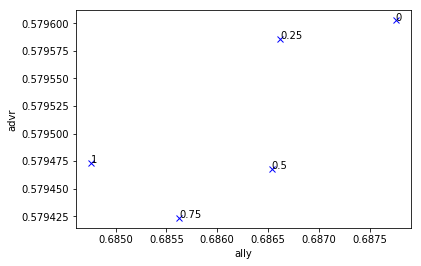

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
plt.xlabel('ally')
plt.ylabel('advr')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

# Ally and Adversary Learning on DP Data

In [69]:
def laplaceMechanism(x, epsilon):
    x +=  torch.Tensor(np.random.laplace(0, 1.0/epsilon, x.shape)).cuda()
    return x

In [70]:
epsilon = 1

In [71]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

lr = 0.0001

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

dp_ally_train = []
dp_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    
    y_ally_train_torch_hat = network_ally_pca(X_train_iter)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    dp_ally_train.append(loss.item())
    dp_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.76253825 	 0.76052600
50 	 0.72129041 	 0.74328870
100 	 0.68949819 	 0.73422170
150 	 0.66903716 	 0.72967964
200 	 0.65249658 	 0.72743112
250 	 0.63737863 	 0.72676897
300 	 0.62397522 	 0.72671586
350 	 0.61386341 	 0.72704297
400 	 0.60251671 	 0.72736669
450 	 0.59288073 	 0.72770149
500 	 0.58512378 	 0.72795087


In [72]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

dp_advr_train = []
dp_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    y_advr_train_torch_hat = network_advr_pca(X_train_iter)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    dp_advr_train.append(loss.item())
    dp_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65482801 	 0.66092533
50 	 0.48808381 	 0.65732765
100 	 0.46473584 	 0.65569705
150 	 0.45834824 	 0.65551311
200 	 0.45551562 	 0.65557629
250 	 0.45401582 	 0.65264708
300 	 0.45322618 	 0.65193099
350 	 0.45266110 	 0.65095538
400 	 0.45227519 	 0.65089673
450 	 0.45201150 	 0.65147430
500 	 0.45182702 	 0.65175587


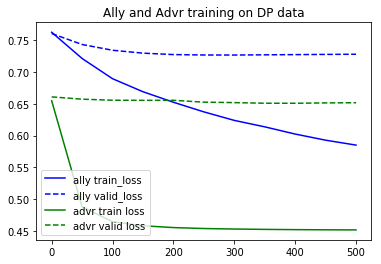

In [73]:
plt.plot(n_epoch, dp_ally_train, 'b')
plt.plot(n_epoch, dp_ally_valid, 'b--')
plt.plot(n_epoch, dp_advr_train, 'g')
plt.plot(n_epoch, dp_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on DP data")
plt.show()

In [74]:
epsilons = [1, 26, 51, 71, 101,]

1 0.5426309108734131 0.7060078978538513
1 0.4518492817878723 0.6636334657669067


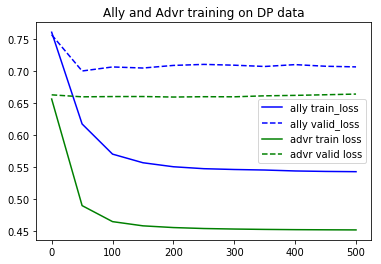

26 0.5458443760871887 0.6572889685630798
26 0.45249730348587036 0.5415685772895813


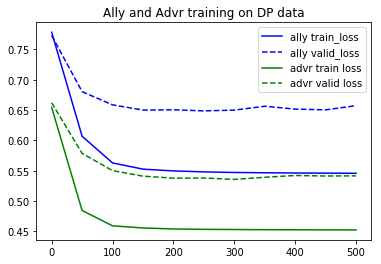

51 0.5455310344696045 0.6685695648193359
51 0.4545918107032776 0.5106186866760254


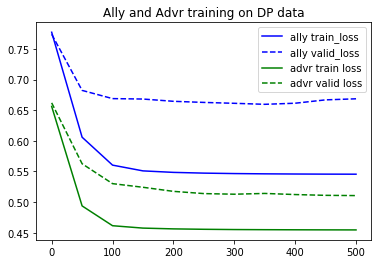

71 0.5448472499847412 0.6423647403717041
71 0.4536183476448059 0.5093000531196594


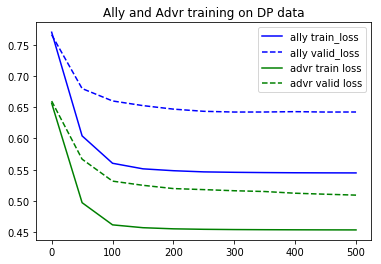

101 0.5454189777374268 0.6542949676513672
101 0.4568032920360565 0.4917466938495636


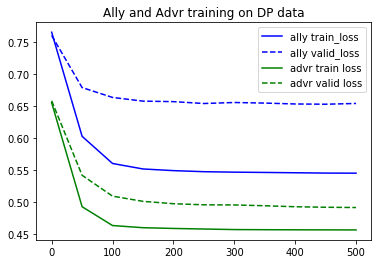

In [77]:
ally_dp_over_epsilons = []
advr_dp_over_epsilons = []
for epsilon in epsilons:
    X_train_pca_torch = torch.Tensor(X_train_reduced)
    X_valid_pca_torch = torch.Tensor(X_valid_reduced)

    lr = 0.001

    network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

    dp_ally_train = []
    dp_ally_valid = []

    X_train_pca_torch = X_train_pca_torch.to(device)
    X_valid_pca_torch = X_valid_pca_torch.to(device)
    y_ally_train_torch = y_ally_train_torch.to(device)
    y_ally_valid_torch = y_ally_valid_torch.to(device)

    for epoch in range(501):
        network_ally_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)

        y_ally_train_torch_hat = network_ally_pca(X_train_iter)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_ally_pca.eval()
        y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

        dp_ally_train.append(loss.item())
        dp_ally_valid.append(ally_valid_loss)

    ally_dp_over_epsilons.append(ally_valid_loss.item())
    print(epsilon, loss.item(), ally_valid_loss.item())

    lr = 0.001

    network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

    y_advr_train_torch = y_advr_train_torch.to(device)
    y_advr_valid_torch = y_advr_valid_torch.to(device)

    dp_advr_train = []
    dp_advr_valid = []

    for epoch in range(501):
        network_advr_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
        y_advr_train_torch_hat = network_advr_pca(X_train_iter)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_advr_pca.eval()
        y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

        dp_advr_train.append(loss.item())
        dp_advr_valid.append(advr_valid_loss)

    print(epsilon, loss.item(), advr_valid_loss.item())
    advr_dp_over_epsilons.append(advr_valid_loss.item())
    
    plt.plot(n_epoch, dp_ally_train, 'b')
    plt.plot(n_epoch, dp_ally_valid, 'b--')
    plt.plot(n_epoch, dp_advr_train, 'g')
    plt.plot(n_epoch, dp_advr_valid, 'g--')
    plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
    plt.title("Ally and Advr training on DP data")
    plt.show()

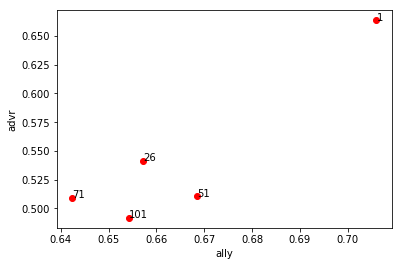

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.xlabel('ally')
plt.ylabel('advr')

for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

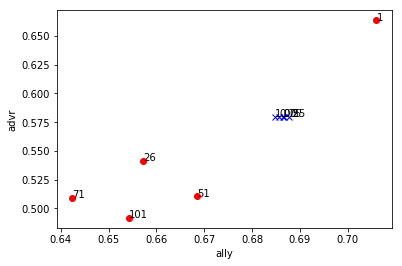

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()

# Ally and Adversary Learning on PCA Data

In [80]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

In [81]:
lr = 0.01

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

pca_ally_train = []
pca_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    pca_ally_train.append(loss.item())
    pca_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.76374066 	 0.72349954
50 	 0.55008167 	 0.66845936
100 	 0.54851484 	 0.66184300
150 	 0.54840654 	 0.66047889
200 	 0.54783833 	 0.66171068
250 	 0.54777372 	 0.66089392
300 	 0.54776132 	 0.66136634
350 	 0.54775375 	 0.66187727
400 	 0.54774839 	 0.66240132
450 	 0.54774439 	 0.66291553
500 	 0.54774123 	 0.66341484


In [82]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

pca_advr_train = []
pca_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    pca_advr_train.append(loss.item())
    pca_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65674174 	 0.65915459
50 	 0.49490258 	 0.53956014
100 	 0.46383363 	 0.51008040
150 	 0.46026722 	 0.50232041
200 	 0.45911494 	 0.49885374
250 	 0.45855895 	 0.49677065
300 	 0.45824513 	 0.49534035
350 	 0.45804644 	 0.49427712
400 	 0.45791250 	 0.49341455
450 	 0.45781389 	 0.49272081
500 	 0.45764181 	 0.49209887


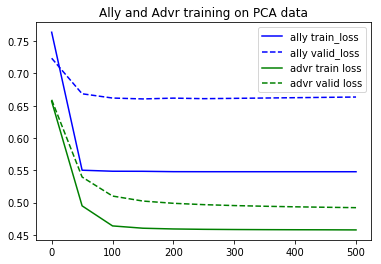

In [83]:
plt.plot(n_epoch, pca_ally_train, 'b')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_train, 'g')
plt.plot(n_epoch, pca_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on PCA data")
plt.show()

# Ally and Adversary Training on Auto-encoded data

In [84]:
lr = 0.001

network_ally_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

ae_ally_train=[]
ae_ally_valid = []

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    ae_ally_train.append(loss.item())
    ae_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.74545979 	 0.74026924
50 	 0.69416636 	 0.69738418
100 	 0.69367760 	 0.69583064
150 	 0.69348574 	 0.69509149
200 	 0.69338483 	 0.69465035
250 	 0.69332486 	 0.69436103
300 	 0.69328588 	 0.69415826
350 	 0.69325894 	 0.69400889
400 	 0.69323951 	 0.69389468
450 	 0.69322491 	 0.69380498
500 	 0.69321364 	 0.69373256


In [85]:
lr = 0.001

network_advr_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

ae_advr_train = []
ae_advr_valid = []

for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    ae_advr_train.append(loss.item())
    ae_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65779179 	 0.66174018
50 	 0.56348413 	 0.59723198
100 	 0.49766693 	 0.55682248
150 	 0.47287455 	 0.54570913
200 	 0.46355247 	 0.53932190
250 	 0.45964050 	 0.53784478
300 	 0.45790765 	 0.53709656
350 	 0.45696402 	 0.53657067
400 	 0.45638981 	 0.53624070
450 	 0.45601282 	 0.53600883
500 	 0.45575103 	 0.53583521


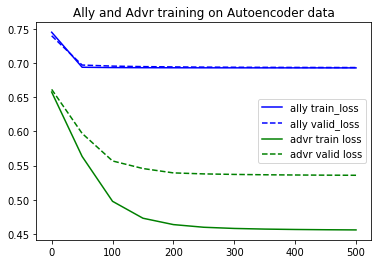

In [86]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | 0.54596204 | **0.63508838** | 0.45774460 | 0.47422782 |
| A-Enc | 0.69294691 | 0.69324082 | 0.45286497 | 0.50768989 |
| P-GAN | 0.53968185 | 0.69574529 | 0.45563743 | **0.59513420** |

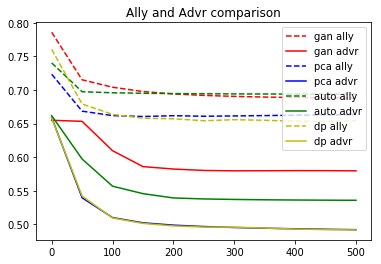

In [87]:
plt.plot(n_epoch, valid, 'r--')
plt.plot(n_epoch, valid_a, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.plot(n_epoch, dp_ally_valid, 'y--')
plt.plot(n_epoch, dp_advr_valid, 'y')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr', 'dp ally', 'dp advr'])
plt.title("Ally and Advr comparison")
plt.show()

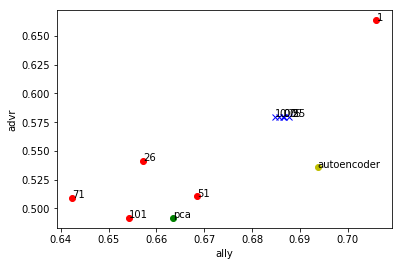

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.plot([pca_ally_valid[-1]], [pca_advr_valid[-1]], 'go')
ax.annotate('%s' % 'pca', xy=(pca_ally_valid[-1], pca_advr_valid[-1]), textcoords='data')
plt.plot([ae_ally_valid[-1]], [ae_advr_valid[-1]], 'yo')
ax.annotate('%s' % 'autoencoder', xy=(ae_ally_valid[-1], ae_advr_valid[-1]), textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()